# Bayesian Inference and Tensorflow Probability

Varun Nayyar
22/05/2019

This is a simplistic introduction to Bayesian Inference and Tensorflow Probability. As of writing, TFP is quite young and the code in this notebook will likely be out of date. 
The code here is written to maximize clarity, not speed and 

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_probability as tfp
tfd = tfp.distributions

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14

# What is Bayesian Inference?

In our default statistical interpretation, we see some data and try and build a model which is defined by it's parameters. A normal distribution by it's mean and variance, a linear regression by it's intercept and slopes etc. 

We choose these parameters to maximize the fit. For example, seeing 6 heads / 4 tails in 10 tosses means we choose P(head) = 0.6. For any other value of p, the chances of seeing 6H/4T is lower. This is the concept of Maximum Likelihood.

But the problem is that these processes have randomness.  Even if we know a coin is 50% heads and 50% tails, tossing it 10 times will only have a 5H/5T split 25% of the time. If we get 6H/4T, does this mean that the coin is biased? 

Obviously not, and here we come up across some of the limitations of Freqentism. We can use confidence intervals and say there is not enough evidence to say the coin is biased, but we can't comment on the coin's lack of bias either. When we make predictions, we're using the biased value of 0.6 despite the fact that the true underlying process could be fair.

Bayesianism instead, accepts that we have some uncertatinty on these parameters. At it's core, Bayesianism treats our parameters as uncertain values and tries to incorporate that uncertainty.

Let's explore some of these ideas with tensorflow probability

In [3]:

def binomial_sample(p, n, trials):
    """
    Tensorflow probability is still quite young, binomial sampling is 
    currently not implemented. It's not super useful, so it hasn't seen much
    usage yet.
    otherwise we could do tfd.Binomial(n, probs=p).sample(trials)
    """
    d = tfd.Bernoulli(probs=p)
    return tf.math.reduce_sum(d.sample((n, trials)), axis=0).numpy()

def plot_dist(dist, p=None):
    if not p:
        p = np.linspace(0, 100)/100
    y = dist.prob(p)
    plt.plot(p,y)



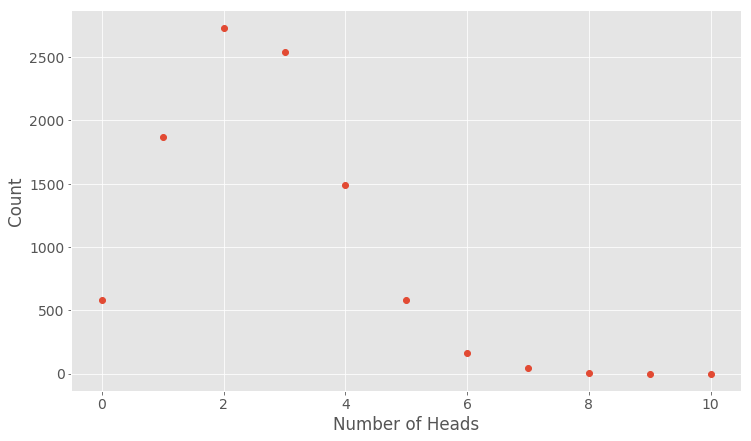

In [4]:
p = 0.25
n= 10
trials = 10000
dat = binomial_sample(p, n, trials)

heights, bins = np.histogram(dat, np.arange(0,12))
# drop last bin since it's there to ensure we separate 9 and 10
# since np.histogram is left associative
bins = bins[:-1]
p = plt.plot(bins, heights, "o")
plt.xlabel("Number of Heads")
plt.ylabel("Count");


This tells us that despite having a fixed true parameter, our MLE can shift around depending on how the data is drawn. We will choose p=0.2 the most often for this dataset and never choose p=0.25 as this is never an option.

Let's invert the problem somewhat. Instead of choosing the parameters that maximize our data, we instead consider the inverse issue, in that for various $p$ what's the likelihood of seeing the data.

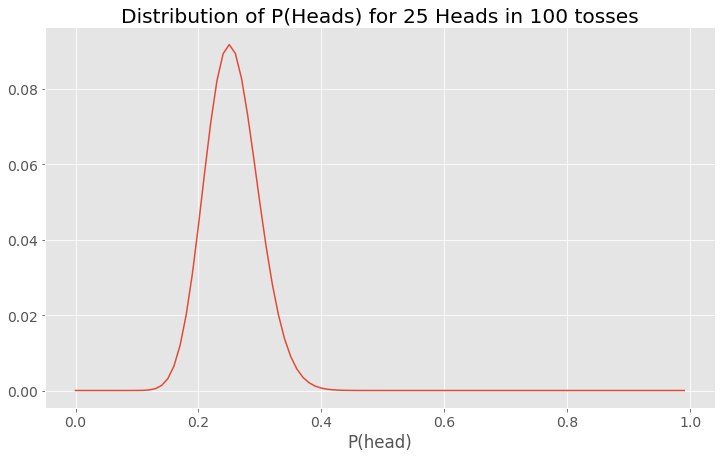

In [5]:
n =100
num_heads = 25

probs = tf.range(0, 100)/100
d = tfd.Binomial(n, probs=probs)
dat = d.prob(num_heads).numpy()
plt.plot(probs, dat)
plt.title(f"Distribution of P(Heads) for {num_heads} Heads in {n} tosses")
plt.xlabel("P(head)");

We can see from the above that the randomness from the data is now incorporated into our parameter estimates. We're no longer just picking one value that maximizes the likelhood, we're now looking at all the possible values of P(Head) and seeing how probable each is. We have a distribution and this is where the power and complexity of Bayesian Stats lies.

## Bayesian Models

Let us define the problem a bit more formally

- Number of Heads ~ Binomial(N, p)
- p ~ Uniform(0,1)


We have a dataset with N (number of tosses) and Number of Heads. We define these as related via the Binomial distribution which is parameterised by P, which we don't know. We define a prior which suggests us possible values of p. We've chosen a Uniform, but any distribution that suggests values in [0,1] would be good.


Let's see how we do this in Tensorflow probability. We need to calculate the log posterior (or the joint log likelihood) and give it to tf.
From Bayes Rule:

- Posterior ~ Likelihood x Prior
- Log Posterior ~ LogLikelihood + LogPrior

In [6]:
# we have log probabilities included for all distributions!
# note the uniform distribution has p=1 for all values in 0,1, 
# hence it's log prob is 0
test_p = 0.3

d = tfd.Uniform()
d.log_prob(test_p).numpy()

0.0

0.5766039


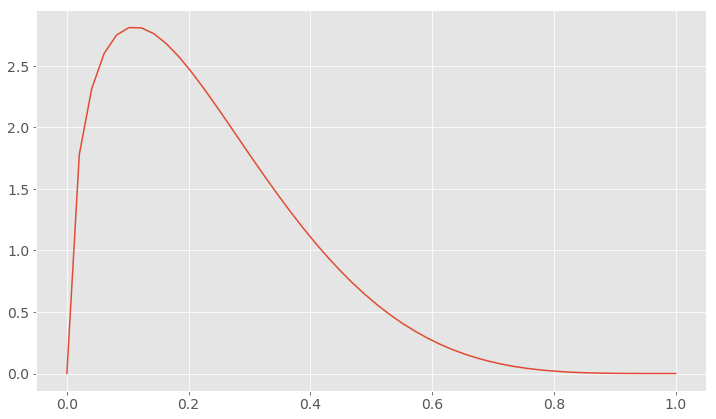

In [7]:
test_p = 0.3
d = tfd.Beta(1.5, 5)
print(d.log_prob(test_p).numpy())
plot_dist(d)

In [8]:
# to calculate log likelihood, we need to do something similar for Numheads
# note how the number of tosses and heads are the data
# while p is the param,
test_n = 10
test_heads= 5


tfd.Binomial(test_n, probs=test_p).log_prob(test_heads).numpy()

-2.2738094

In [9]:
# let's define some functions here

def log_like_prior(p):
    prior_dist = tfd.Uniform()
#     prior_dist = tfd.Beta(5, 5)
    return prior_dist.log_prob(p)

n = 10
heads = 2

# we will create a closure to simplify the tfp api
# closures are functions that have data
def ll_data(p):
    return tfd.Binomial(n, probs=p).log_prob(heads)

# hence the joint_ll or the log posterior simply depends on p!
def joint_ll(p):
    return log_like_prior(p) + ll_data(p)

MCMC Sampling is a big part of Bayesian Inference. However, we'll just accept the block below for today as MCMC is a topic in itself

In [10]:

num_results = 1000
num_burnin_steps = 100

states, kernel_results = tfp.mcmc.sample_chain(
  num_results=num_results,
  num_burnin_steps=num_burnin_steps,
  current_state=[
      [heads/n], 
      # we give it a good initial point to get some nice viz
      # giving it more time to find the areas of high probability will overcome 
      # bad starting conditions
  ],
  kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=joint_ll,
      step_size=0.1,
      num_leapfrog_steps=3),
  parallel_iterations=5)


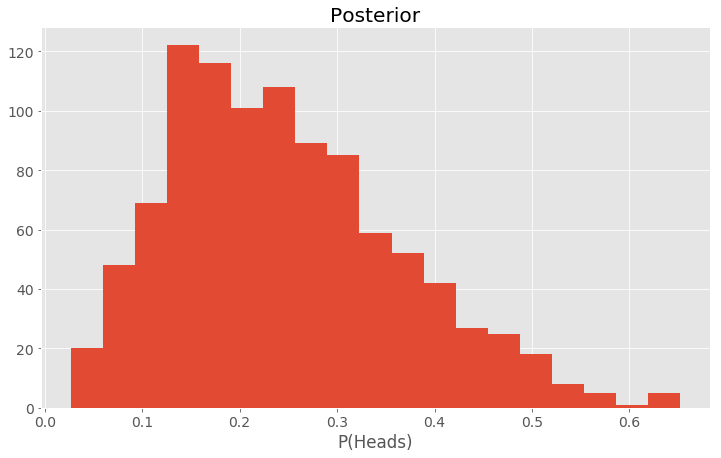

In [11]:
# we could have more params, but since we have only one, let's 
# just grab that
sampled_p = states[0].numpy().squeeze()
plt.hist(sampled_p, "auto")
plt.title("Posterior")
plt.xlabel("P(Heads)");

This is only a toy problem, to get people comfortable with the syntax. But we were able to sample from our posterior without doing much work at all!

## Bayesian Linear Regression



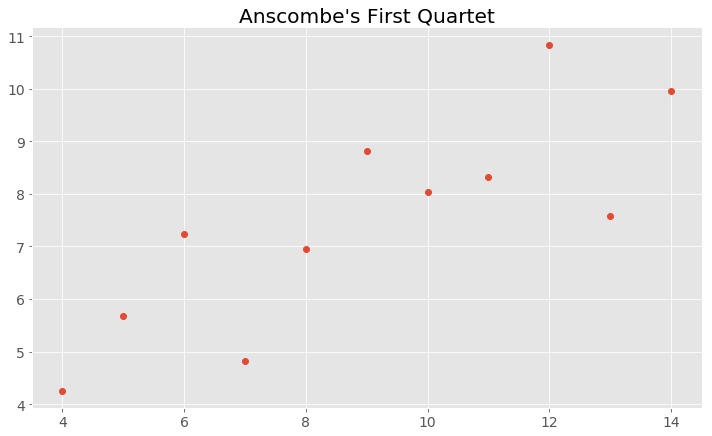

In [48]:
# let's use anscombes' quartet
x1 = np.array([10,8,13,9,11,14,6,4,12,7,5], dtype=np.float32)
y1 = np.array([8.04,6.95,7.58,8.81,8.33,9.96,7.24,4.26,10.84,4.82,5.68], dtype=np.float32)
y2 = np.array([9.14,8.14,8.74,8.77,9.26,8.10,6.13,3.10,9.13,7.26,4.74], dtype=np.float32)
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73], dtype=np.float32)

plt.plot(x1, y1, 'o')
plt.title("Anscombe's First Quartet");

Remember a simple linear model for data (x,y)

y ~ Normal(intercept + slope * x, variance)

To add some priors on this, let
 - intercept~ N(0,1)
 - slope ~ N(0,1)
 - sd ~ Exp(1)
 
 

In [73]:
def scale(x):
    """
    Centering and Scaling is always a good idea for 
    data. We do this to make our priors and initial guesses
    This also reduces spurious correlations
    This is not necessary.
    """
    return tf.convert_to_tensor((x - x.mean())/x.std())
    

def log_linear_prior(intercept, slope, sd):
    int_prior = tfd.Normal(0.0, 1.0)
    slope_prior = tfd.Normal(0.0,1.0)
    sd_prior = tfd.Exponential(1.0)
    return tf.reduce_sum([int_prior.log_prob(intercept), 
                          slope_prior.log_prob(slope), 
                          sd_prior.log_prob(slope)])
    
# closure again
x1t = scale(x1)
y1t = scale(y1)
    
def log_linear_ll(intercept, slope, sd):
    yhat = intercept + slope * x1t
    yd = tfd.Normal(yhat, sd)
    return tf.reduce_sum(yd.log_prob(y1t))

def log_linear_posterior(intercept, slope, sd):

    return log_linear_ll(intercept, slope, sd) + log_linear_prior(intercept, slope, sd)
    

In [14]:
# this can be quite slow in eager mode
num_results = 3000
num_burnin_steps = 1000

states, kernel_results = tfp.mcmc.sample_chain(
  num_results=num_results,
  num_burnin_steps=num_burnin_steps,
  current_state=[
      0.0, 0.0, 1.0
      # we give it a good initial point to get some nice viz
      # giving it more time to find the areas of high probability will overcome 
      # bad starting conditions
  ],
  kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=log_linear_posterior,
      step_size=0.1,
      num_leapfrog_steps=3),
  parallel_iterations=1)


In [15]:
intercept, slope, sd = states

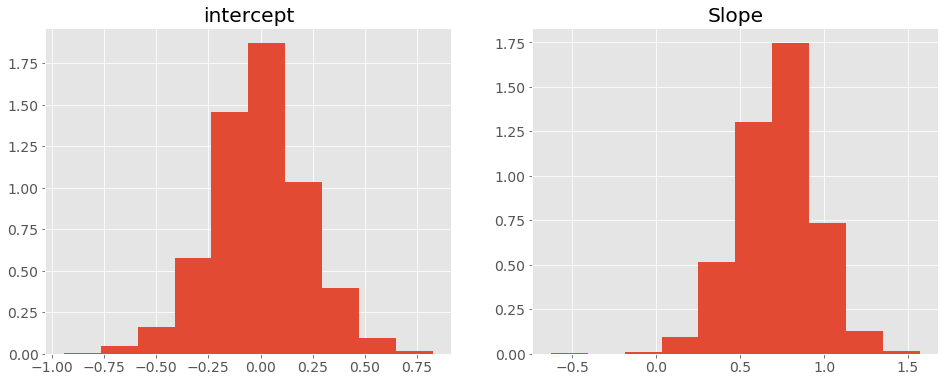

In [16]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.hist(intercept, density=True);
plt.title("intercept")
plt.subplot(122)
plt.hist(slope, density=True);
plt.title("Slope");

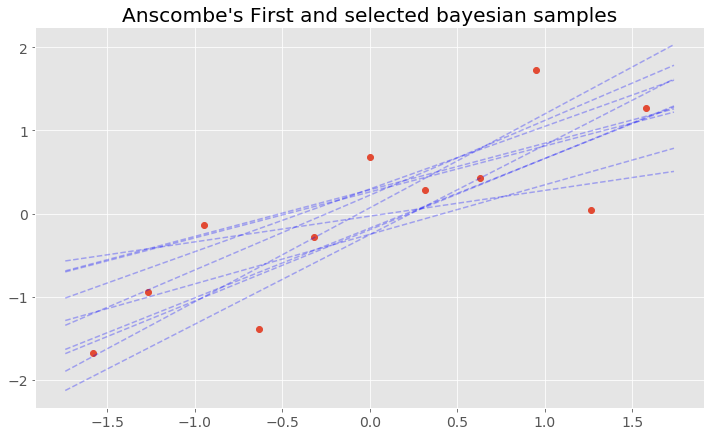

In [17]:
# let's sample some of it

def abline(slope, intercept, xlim=None, **kwargs):
    """Plot a line from slope and intercept. Source, stackoverflow"""
    axes = plt.gca()
    if not xlim:
        xlim = axes.get_xlim()
    x_vals = np.array(xlim)
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, 'b--', alpha=0.3, **kwargs)

plt.plot(x1t, y1t, 'o');
xl = plt.xlim()
for i in range(10):
    index = np.random.randint(0, len(slope))
    s, i = slope[index], intercept[index]
    abline(s, i, xl)
plt.title("Anscombe's First and selected bayesian samples");

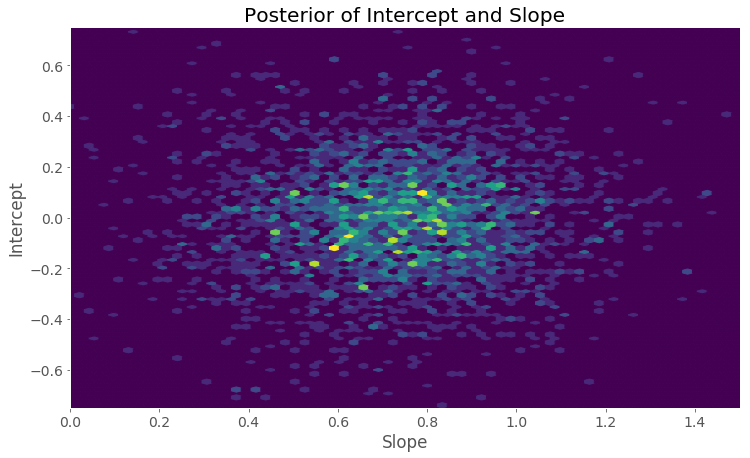

In [18]:
plt.hexbin(slope, intercept)
plt.xlim((0, 1.5))
plt.ylim((-.75, .75))
plt.ylabel("Intercept")
plt.xlabel("Slope")
plt.title("Posterior of Intercept and Slope");

Let's try a new way of defining the same problem, this time with `edward`, which is much higher level.

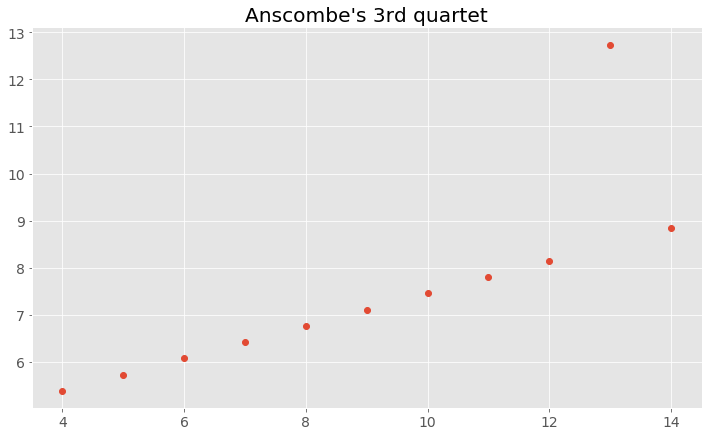

In [172]:
plt.plot(x1, y3, 'o')
plt.title("Anscombe's 3rd quartet");

In [99]:
from tensorflow_probability import edward2 as ed

x1t = tf.convert_to_tensor(scale(x1))
y3t = tf.convert_to_tensor(scale(y3))

def linear_regression(x, intercept, slope, sd):
    """
    Define in purely terms of distributions
    We need the names defined for this method
    """
    slope_d = ed.Normal(0, 1, name="slope")
    intercept_d = ed.Normal(0, 1, name="intercept")
    sd_d = ed.Exponential(1, name="sd")
    return ed.Normal(x * slope_d + intercept_d, sd, name="y")

# use edward to create the log prob function automatically
log_joint = ed.make_log_joint_fn(linear_regression)

# make a closure here to make this entirely in terms of the 
# parameters
def target_log_prob_fn(intercept, slope, sd):
    return log_joint(x1t, slope=slope, intercept=intercept, 
                     sd=sd, y=y3t)

In [39]:
target_log_prob_fn(10.0, 0.0, 1.0)

<tf.Tensor: id=8113373, shape=(), dtype=float32, numpy=-618.4462>

In [130]:
# same method as before
num_results = 1000
num_burnin_steps = 100

states, kernel_results = tfp.mcmc.sample_chain(
  num_results=num_results,
  num_burnin_steps=num_burnin_steps,
  current_state=[
      0.0, 0.0, 1.0
      # we give it a good initial point to get some nice viz
      # giving it more time to find the areas of high probability will overcome 
      # bad starting conditions
  ],
  kernel=tfp.mcmc.HamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      step_size=0.1,
      num_leapfrog_steps=3),
  parallel_iterations=1)


In [131]:
intercept, slope, sd = states

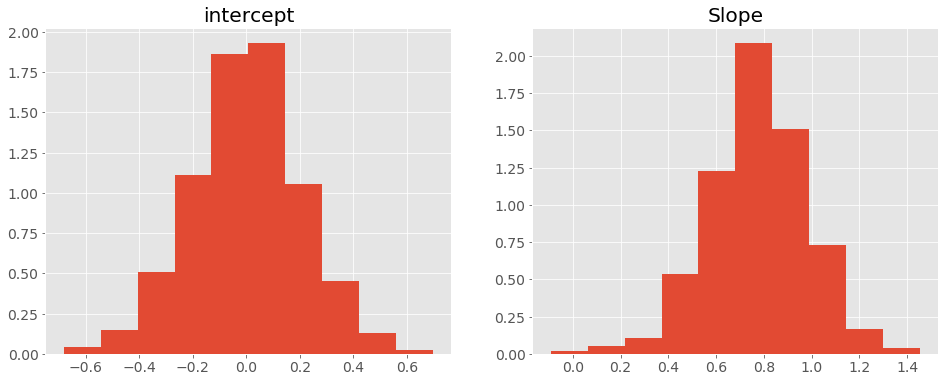

In [132]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.hist(intercept, density=True);
plt.title("intercept")
plt.subplot(122)
plt.hist(slope, density=True);
plt.title("Slope");

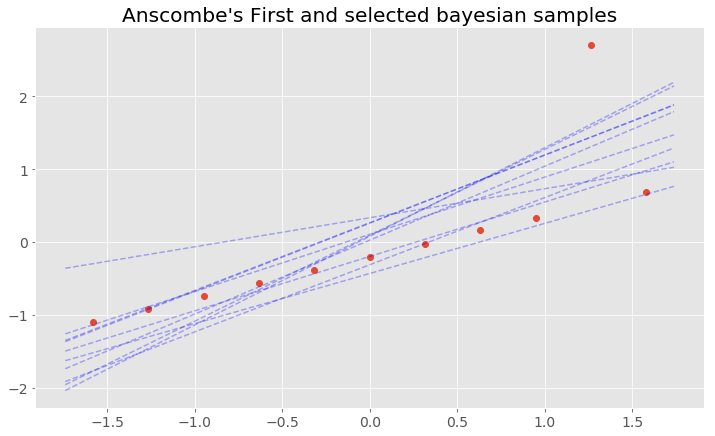

In [133]:
plt.plot(x1t, y3t, 'o');
xl = plt.xlim()
for i in range(10):
    index = np.random.randint(0, len(slope))
    s, i = slope[index], intercept[index]
    abline(s, i, xl)
plt.title("Anscombe's First and selected bayesian samples");

In [147]:
d = linear_regression(0.5, intercept, slope, sd)
?d.eval

## Exercises

1. Can you get a better more robust regression to the above? Yes!
Change the final model of `linear_regression` to a T distribution (`ed.StudentT`  with df=2). See what happens. Increase the df ~ 500. What happens? 
https://www.tensorflow.org/probability/api_docs/python/tfp/edward2/StudentT

2. Experiment with different priors and not scaling the data.
    - Change the Sd prior to be much wider (say uniform (0,50)) and see what happens
    - Don't scale the data (center your priors and initial guesses on the anscombe solution) and check the hexbin
    - Make your priors on slope and intercept much tighter and much looser (by changing the sd=1) and see how your posterior changes. Try this on

3. Apply linear regression to the height data below
    1. Predict height from weight
    2. Predict height from log-weight

4. Make the above version a multiple linear regression! Use foxes to test it out.
    1. Predict weight ~ avgfood
    2. Predict weight ~ avgfood + groupsize




In [173]:
import pandas as pd
# additional data to try out!
height = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data/Howell1.csv", delimiter=";")
foxes = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data/foxes.csv", delimiter=";")


# Further Resources

1. Tensorflow Probability has some very powerful features. We've only touched the surface! See [this page](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/examples) for more examples. It is quite a young language
2. [STAN](https://mc-stan.org/docs/2_18/stan-users-guide/index.html) and [PyMC3](https://docs.pymc.io/notebooks/api_quickstart.html) are much gentler introductions to Probabilistic programming
3. [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/) is the best introductory text to Bayesian Inference. 